# AI Finance Project - Loda Enrico

In [1]:
!pip install yfinance pmdarima==2.0.4 arch==7.2.0 matplotlib==3.10.3 numpy==1.26.4

In [2]:
# import
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import scipy.stats as sps
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pmdarima as arima
from arch import arch_model

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#fix seeds for riproducibility
np.random.seed(11)
torch.manual_seed(11)

# 1 - Data Collection and Preparation

## Obtaining returns from standar yf dataframe

The assets that were selected for this portfolio are **SPY** and **NVDA**, since we wanted to have a riskier asset and a safer one.


---



We need to calculate the daily simple rate of return of our assets. To do so, we define:

**Simple rate of return**  

$$
r = \frac{\frac{C}{P}-1}{T}
$$

Given:  
- **P**: the price of the asset at the time of investment  
- **T**: maturity (number of periods)  
- **C**: the price of the asset at maturity **T**

---

**Daily simple rate of return:**  
For daily returns, considering $P_t$ as the close price of the asset at time t, the formula is:
$$
r_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

So in this notebook every returns is calculated considering t-1 and t, and we utilize the close prices for the computation

In [3]:
df = yf.download(["SPY","NVDA"], start="2010-01-01", end="2025-05-31") # 2025-05-17
spy = df.xs('SPY', axis=1, level=1)
nvda = df.xs('NVDA', axis=1, level=1)

prices = df["Close"]
returns = (prices / prices.shift(1)) - 1
returns = returns.dropna()
SPY_r = returns['SPY']
NVDA_r = returns['NVDA']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


In [4]:
df

Price            Close                    High                     Low  \
Ticker            NVDA         SPY        NVDA         SPY        NVDA   
Date                                                                     
2010-01-04    0.423884   85.768417    0.426864   85.813824    0.415172   
2010-01-05    0.430073   85.995483    0.434658   86.033326    0.422279   
2010-01-06    0.432824   86.056061    0.433741   86.267965    0.425718   
2010-01-07    0.424342   86.419296    0.432366   86.525248    0.421133   
2010-01-08    0.425259   86.706879    0.428239   86.744721    0.418382   
...                ...         ...         ...         ...         ...   
2025-05-23  131.289993  579.109985  132.679993  581.809998  129.160004   
2025-05-27  135.500000  591.150024  135.660004  591.309998  133.309998   
2025-05-28  134.809998  587.729980  137.250000  592.770020  134.789993   
2025-05-29  139.190002  590.049988  143.490005  593.200012  137.910004   
2025-05-30  135.130005  589.390015  139.619995  591.130005  132.919998   

Price                         Open                 Volume             
Ticker             SPY        NVDA         SPY       NVDA        SPY  
Date                                                                  
2010-01-04   84.391037    0.424342   85.041888  800204000  118944600  
2010-01-05   85.405178    0.422279   85.715470  728648000  111579900  
2010-01-06   85.844157    0.429844   85.912266  649168000  116074400  
2010-01-07   85.654924    0.430532   85.897101  547792000  131091100  
2010-01-08   86.018191    0.420903   86.192253  478168000  126402800  
...                ...         ...         ...        ...        ...  
2025-05-23  575.599976  130.000000  575.979980  198821300   76029000  
2025-05-27  578.429993  134.149994  586.070007  192953600   72588500  
2025-05-28  586.989990  136.029999  591.559998  304021100   68445500  
2025-05-29  586.070007  142.250000  593.059998  369241900   69973300  
2025-05-30  583.239990  138.720001  588.929993  332443400   90471200  

[3876 rows x 10 columns]

In [5]:
returns[:]

Ticker,NVDA,SPY
Date,,
2010-01-05,0.014603,0.002647
2010-01-06,0.006396,0.000704
2010-01-07,-0.019597,0.004221
2010-01-08,0.002161,0.003328
2010-01-11,-0.014016,0.001397
...,...,...
2025-05-23,-0.011594,-0.006826
2025-05-27,0.032066,0.020791
2025-05-28,-0.005092,-0.005785


In [6]:
dates = returns.index.strftime('%Y-%m-%d')
dates

Index(['2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-11',
       '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15', '2010-01-19',
       ...
       '2025-05-16', '2025-05-19', '2025-05-20', '2025-05-21', '2025-05-22',
       '2025-05-23', '2025-05-27', '2025-05-28', '2025-05-29', '2025-05-30'],
      dtype='object', name='Date', length=3875)

##Dataset to train the lstm

We now have a dataframe of the daily SSR for each asset.
In this section, we are transforming the dataframe to create the dataset to train the lstm.

The features of said dataset, for a total of 22, are the following:

*   $[r_1^{t-1},\dots ,r_1^{t-10}]$, $[r_2^{t-1},\dots ,r_2^{t-10}]$
*   $\mu_1$, $\mu_2$ of $r_1$, $r_2$ calculated on the last 10 lags (the means will be given as input after the lstm, look at the architecture to understand better)


The target features are the values of the covariance matrix between the returns of today of both assets  (which are unkown at time t since we are considering the close prices):
* $\Sigma_{t}$

In [7]:
rNVDA_series = returns['NVDA']
rSPY_series = returns['SPY']
df = pd.DataFrame()
df['rNVDA_today'] = rNVDA_series
df['rSPY_today'] = rSPY_series

for i in range(1, 11):
    df[f'rNVDA_t-{i}'] = rNVDA_series.shift(i)
    df[f'rSPY_t-{i}'] = rSPY_series.shift(i)

df.head(11)

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rNVDA_t-6,rSPY_t-6,rNVDA_t-7,rSPY_t-7,rNVDA_t-8,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,-0.019597,0.004221,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,0.002161,0.003328,-0.019597,0.004221,0.006396,0.000704,0.014603,0.002647,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,-0.014016,0.001397,0.002161,0.003328,-0.019597,0.004221,0.006396,0.000704,0.014603,0.002647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-12,-0.033898,-0.009326,-0.014016,0.001397,0.002161,0.003328,-0.019597,0.004221,0.006396,0.000704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-13,0.013582,0.008447,-0.033898,-0.009326,-0.014016,0.001397,0.002161,0.003328,-0.019597,0.004221,...,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-14,-0.015634,0.002704,0.013582,0.008447,-0.033898,-0.009326,-0.014016,0.001397,0.002161,0.003328,...,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-15,-0.029495,-0.011224,-0.015634,0.002704,0.013582,0.008447,-0.033898,-0.009326,-0.014016,0.001397,...,-0.019597,0.004221,0.006396,0.000704,0.014603,0.002647,NaN,NaN,NaN,NaN


In [8]:
rSPY_series

,SPY
Date,
2010-01-05,0.002647
2010-01-06,0.000704
2010-01-07,0.004221
2010-01-08,0.003328
2010-01-11,0.001397
...,...
2025-05-23,-0.006826
2025-05-27,0.020791
2025-05-28,-0.005785


Here we calculate mean considering only the last 10 lags and the variance considering  the last 10 lags and the SSR of today. 

The target will be isolated from the train dataset later

In [9]:
cols = [f'rNVDA_t-{i}' for i in range(1, 11)]
df['mean_NVDA'] = df[cols].mean(axis=1)
cols.append('rNVDA_today')
df['var_NVDA'] = df[cols].var(axis=1)

cols = [f'rSPY_t-{i}' for i in range(1, 11)]
df['mean_SPY'] = df[cols].mean(axis=1)
cols.append('rSPY_today')
df['var_SPY'] = df[cols].var(axis=1)
df = df.dropna()
df#["r2_t-10"]

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rNVDA_t-8,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,0.013582,0.008447,...,-0.019597,0.004221,0.006396,0.000704,0.014603,0.002647,-0.005720,0.000331,0.001539,0.000059
2010-01-21,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,...,0.002161,0.003328,-0.019597,0.004221,0.006396,0.000704,-0.007581,0.000296,0.000258,0.000093
2010-01-22,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,...,-0.014016,0.001397,0.002161,0.003328,-0.019597,0.004221,-0.010007,0.000327,-0.001736,0.000131
2010-01-25,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,...,-0.033898,-0.009326,-0.014016,0.001397,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132
2010-01-26,-0.031661,-0.004190,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,...,0.013582,0.008447,-0.033898,-0.009326,-0.014016,0.001397,-0.010023,0.000424,-0.004207,0.000127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,0.001256,0.001094,...,0.056341,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.012783,0.000736,0.003215,0.000149
2025-05-27,0.032066,0.020791,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,...,0.041638,0.001278,0.056341,0.006604,0.054436,0.033047,0.012237,0.000741,0.002660,0.000177
2025-05-28,-0.005092,-0.005785,0.032066,0.020791,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,...,-0.003768,0.004884,0.041638,0.001278,0.056341,0.006604,0.010000,0.000582,0.001434,0.000091


In [10]:
count = (df['var_SPY'] > df['var_NVDA']).sum()
print(f"The number of times 'var_SPY' is larger than 'var_NVDA' is: {count}")
#print all the variances with that condition
print(df[df['var_SPY'] > df['var_NVDA']][['var_SPY', 'var_NVDA']])

The number of times 'var_SPY' is larger than 'var_NVDA' is: 23
             var_SPY  var_NVDA
Date                          
2013-08-29  0.000062  0.000054
2013-08-30  0.000048  0.000048
2013-09-03  0.000051  0.000045
2013-09-04  0.000054  0.000034
2013-09-05  0.000052  0.000032
2013-09-06  0.000048  0.000031
2013-09-30  0.000034  0.000032
2013-10-01  0.000037  0.000031
2013-10-02  0.000035  0.000029
2013-10-03  0.000023  0.000021
2013-10-08  0.000043  0.000041
2013-10-10  0.000095  0.000073
2013-10-11  0.000097  0.000077
2014-02-10  0.000118  0.000115
2014-10-03  0.000075  0.000074
2014-10-06  0.000075  0.000056
2014-10-07  0.000089  0.000057
2014-10-08  0.000124  0.000105
2014-10-09  0.000147  0.000120
2015-01-05  0.000112  0.000109
2015-08-25  0.000224  0.000208
2015-12-24  0.000158  0.000154
2015-12-28  0.000159  0.000149


Here we calculated the covariance between the SSR of the assets of today plus the last 10 lags

In [11]:
def compute_covariance_row(row):
    r1 = [row[f'rNVDA_t-{i}'] for i in range(1, 11)]
    r1.append(row['rNVDA_today'])

    r2 = [row[f'rSPY_t-{i}'] for i in range(1, 11)]
    r2.append(row['rSPY_today'])

    return np.cov(r1, r2)[0, 1]

df['cov'] = df.apply(compute_covariance_row, axis=1)
df

,rNVDA_today,rSPY_today,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,...,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY,cov
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,0.013582,0.008447,...,0.004221,0.006396,0.000704,0.014603,0.002647,-0.005720,0.000331,0.001539,0.000059,0.000097
2010-01-21,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,...,0.003328,-0.019597,0.004221,0.006396,0.000704,-0.007581,0.000296,0.000258,0.000093,0.000111
2010-01-22,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,...,0.001397,0.002161,0.003328,-0.019597,0.004221,-0.010007,0.000327,-0.001736,0.000131,0.000153
2010-01-25,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,...,-0.009326,-0.014016,0.001397,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132,0.000184
2010-01-26,-0.031661,-0.004190,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,...,0.008447,-0.033898,-0.009326,-0.014016,0.001397,-0.010023,0.000424,-0.004207,0.000127,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,0.001256,0.001094,...,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.012783,0.000736,0.003215,0.000149,0.000241
2025-05-27,0.032066,0.020791,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,...,0.001278,0.056341,0.006604,0.054436,0.033047,0.012237,0.000741,0.002660,0.000177,0.000267
2025-05-28,-0.005092,-0.005785,0.032066,0.020791,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,...,0.004884,0.041638,0.001278,0.056341,0.006604,0.010000,0.000582,0.001434,0.000091,0.000149


Drop the returns of the day, since we assume to not have the close price of the day at the time of the choice of the investment

In [12]:
df_r = df.loc[:][['rNVDA_today', 'rSPY_today']]
df.drop(['rNVDA_today', 'rSPY_today'], axis=1, inplace=True)
df

,rNVDA_t-1,rSPY_t-1,rNVDA_t-2,rSPY_t-2,rNVDA_t-3,rSPY_t-3,rNVDA_t-4,rSPY_t-4,rNVDA_t-5,rSPY_t-5,...,rSPY_t-8,rNVDA_t-9,rSPY_t-9,rNVDA_t-10,rSPY_t-10,mean_NVDA,var_NVDA,mean_SPY,var_SPY,cov
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,0.013582,0.008447,-0.033898,-0.009326,...,0.004221,0.006396,0.000704,0.014603,0.002647,-0.005720,0.000331,0.001539,0.000059,0.000097
2010-01-21,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,0.013582,0.008447,...,0.003328,-0.019597,0.004221,0.006396,0.000704,-0.007581,0.000296,0.000258,0.000093,0.000111
2010-01-22,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,-0.015634,0.002704,...,0.001397,0.002161,0.003328,-0.019597,0.004221,-0.010007,0.000327,-0.001736,0.000131,0.000153
2010-01-25,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,-0.029495,-0.011224,...,-0.009326,-0.014016,0.001397,0.002161,0.003328,-0.011507,0.000395,-0.004387,0.000132,0.000184
2010-01-26,0.017011,0.005128,-0.034604,-0.022292,-0.017857,-0.019229,-0.004016,-0.010168,0.018702,0.012495,...,0.008447,-0.033898,-0.009326,-0.014016,0.001397,-0.010023,0.000424,-0.004207,0.000127,0.000175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,0.001256,0.001094,0.004227,0.006334,...,0.006604,0.054436,0.033047,-0.006134,-0.001274,0.012783,0.000736,0.003215,0.000149,0.000241
2025-05-27,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,0.001256,0.001094,...,0.001278,0.056341,0.006604,0.054436,0.033047,0.012237,0.000741,0.002660,0.000177,0.000267
2025-05-28,0.032066,0.020791,-0.011594,-0.006826,0.007815,0.000395,-0.019199,-0.016851,-0.008778,-0.003362,...,0.004884,0.041638,0.001278,0.056341,0.006604,0.010000,0.000582,0.001434,0.000091,0.000149


In [13]:
df_r

,rNVDA_today,rSPY_today
Date,,
2010-01-20,-0.004016,-0.010168
2010-01-21,-0.017857,-0.019229
2010-01-22,-0.034604,-0.022292
2010-01-25,0.017011,0.005128
2010-01-26,-0.031661,-0.004190
...,...,...
2025-05-23,-0.011594,-0.006826
2025-05-27,0.032066,0.020791
2025-05-28,-0.005092,-0.005785


### Separate train, validation and test
The split for validation was implemented in order to decide the parameters of our architecture

In [14]:
train_df = df.loc["2010-01-01":"2022-12-31"]
validation_df = df.loc["2023-01-01":"2023-12-31"]
test_df  = df.loc["2024-01-01":]
print((len(train_df) + len(validation_df) + len(test_df)) == len(df))

True


Flip the columns in order to have a temporal sequence from past to present as:

$[r_1^{t-10}, r_2^{t-10}, \dots, r_1^{t-1}, r_2^{t-1}]$

In [15]:
train_df = train_df[train_df.columns[::-1]]
validation_df = validation_df[validation_df.columns[::-1]]
test_df = test_df[test_df.columns[::-1]]

In [16]:
train_df

,cov,var_SPY,mean_SPY,var_NVDA,mean_NVDA,rSPY_t-10,rNVDA_t-10,rSPY_t-9,rNVDA_t-9,rSPY_t-8,...,rSPY_t-5,rNVDA_t-5,rSPY_t-4,rNVDA_t-4,rSPY_t-3,rNVDA_t-3,rSPY_t-2,rNVDA_t-2,rSPY_t-1,rNVDA_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-20,0.000097,0.000059,0.001539,0.000331,-0.005720,0.002647,0.014603,0.000704,0.006396,0.004221,...,-0.009326,-0.033898,0.008447,0.013582,0.002704,-0.015634,-0.011224,-0.029495,0.012495,0.018702
2010-01-21,0.000111,0.000093,0.000258,0.000296,-0.007581,0.000704,0.006396,0.004221,-0.019597,0.003328,...,0.008447,0.013582,0.002704,-0.015634,-0.011224,-0.029495,0.012495,0.018702,-0.010168,-0.004016
2010-01-22,0.000153,0.000131,-0.001736,0.000327,-0.010007,0.004221,-0.019597,0.003328,0.002161,0.001397,...,0.002704,-0.015634,-0.011224,-0.029495,0.012495,0.018702,-0.010168,-0.004016,-0.019229,-0.017857
2010-01-25,0.000184,0.000132,-0.004387,0.000395,-0.011507,0.003328,0.002161,0.001397,-0.014016,-0.009326,...,-0.011224,-0.029495,0.012495,0.018702,-0.010168,-0.004016,-0.019229,-0.017857,-0.022292,-0.034604
2010-01-26,0.000175,0.000127,-0.004207,0.000424,-0.010023,0.001397,-0.014016,-0.009326,-0.033898,0.008447,...,0.012495,0.018702,-0.010168,-0.004016,-0.019229,-0.017857,-0.022292,-0.034604,0.005128,0.017011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.000335,0.000156,-0.003457,0.000964,-0.010718,-0.007470,-0.009785,0.014417,0.031410,0.007570,...,-0.011806,-0.022475,-0.008480,-0.019130,0.001369,-0.010397,0.014952,0.025862,-0.014266,-0.070420
2022-12-27,0.000345,0.000154,-0.002135,0.001299,-0.010607,0.014417,0.031410,0.007570,0.030625,-0.006393,...,-0.008480,-0.019130,0.001369,-0.010397,0.014952,0.025862,-0.014266,-0.070420,0.005752,-0.008671
2022-12-28,0.000246,0.000129,-0.003971,0.001070,-0.020883,0.007570,0.030625,-0.006393,-0.022023,-0.024462,...,0.001369,-0.010397,0.014952,0.025862,-0.014266,-0.070420,0.005752,-0.008671,-0.003943,-0.071353


In [17]:
test_df

,cov,var_SPY,mean_SPY,var_NVDA,mean_NVDA,rSPY_t-10,rNVDA_t-10,rSPY_t-9,rNVDA_t-9,rSPY_t-8,...,rSPY_t-5,rNVDA_t-5,rSPY_t-4,rNVDA_t-4,rSPY_t-3,rNVDA_t-3,rSPY_t-2,rNVDA_t-2,rSPY_t-1,rNVDA_t-1
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,0.000084,0.000042,0.001121,0.000290,0.002503,-0.001647,0.011169,0.005625,0.024279,0.006081,...,0.002010,-0.003266,0.004222,0.009195,0.001808,0.002801,0.000378,0.002125,-0.002895,0.000000
2024-01-03,0.000096,0.000048,0.000726,0.000287,-0.001348,0.005625,0.024279,0.006081,-0.009445,-0.013857,...,0.004222,0.009195,0.001808,0.002801,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341
2024-01-04,0.000076,0.000045,-0.000653,0.000227,-0.005020,0.006081,-0.009445,-0.013857,-0.030098,0.009482,...,0.001808,0.002801,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436
2024-01-05,0.000087,0.000041,-0.001584,0.000285,-0.003173,-0.013857,-0.030098,0.009482,0.018270,0.002010,...,0.000378,0.002125,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436,-0.003221,0.009019
2024-01-08,0.000128,0.000042,-0.000061,0.000542,0.002126,0.009482,0.018270,0.002010,-0.003266,0.004222,...,-0.002895,0.000000,-0.005596,-0.027341,-0.008167,-0.012436,-0.003221,0.009019,0.001370,0.022897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-23,0.000241,0.000149,0.003215,0.000736,0.012783,-0.001274,-0.006134,0.033047,0.054436,0.006604,...,0.006334,0.004227,0.001094,0.001256,-0.003362,-0.008778,-0.016851,-0.019199,0.000395,0.007815
2025-05-27,0.000267,0.000177,0.002660,0.000741,0.012237,0.033047,0.054436,0.006604,0.056341,0.001278,...,0.001094,0.001256,-0.003362,-0.008778,-0.016851,-0.019199,0.000395,0.007815,-0.006826,-0.011594
2025-05-28,0.000149,0.000091,0.001434,0.000582,0.010000,0.006604,0.056341,0.001278,0.041638,0.004884,...,-0.003362,-0.008778,-0.016851,-0.019199,0.000395,0.007815,-0.006826,-0.011594,0.020791,0.032066


We created a class for the dataset of the lstm, this class automatically separate the features from the targets and apply a scaler in order to have numerical stability in training process

In [18]:
scaler_feature  = StandardScaler()
scaler_target = StandardScaler()

class LSTMdataset(Dataset):
    def __init__(self, dataframe, train):
        super().__init__()

        feature_dataframe = dataframe.drop(['cov', 'var_NVDA', 'var_SPY'], axis=1)
        target_dataframe = dataframe[['cov', 'var_NVDA', 'var_SPY']]

        if train:
          feature_dataframe = scaler_feature.fit_transform(feature_dataframe)
          target_dataframe = scaler_target.fit_transform(target_dataframe)
        else:
          feature_dataframe = scaler_feature.transform(feature_dataframe)
          target_dataframe = scaler_target.transform(target_dataframe)

        self.X = torch.tensor(feature_dataframe, dtype=torch.float32)
        self.y = torch.tensor(target_dataframe, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
# pre normalization
col_names = ['cov', 'var_NVDA', 'var_SPY']
for name in col_names:
    print(f"{name}: min={train_df[name].min():.6f}, max={train_df[name].max():.6f}")

cov: min=-0.000185, max=0.007358
var_NVDA: min=0.000019, max=0.011850
var_SPY: min=0.000002, max=0.004897


In [20]:
# post normalization
train_dataset = LSTMdataset(train_df, train=True)
train_dataset[3]


# Get all targets from the dataset as a tensor
all_targets = train_dataset[:][1]  # shape: (num_samples, 3)

# Convert to numpy array
all_targets_np = all_targets.numpy()

# Print min and max for each column (cov, var_NVDA, var_SPY)
col_names = ['cov', 'var_NVDA', 'var_SPY']
for i, name in enumerate(col_names):
    print(f"{name}: min={all_targets_np[:, i].min():.6f}, max={all_targets_np[:, i].max():.6f}")

cov: min=-0.866733, max=16.036280
var_NVDA: min=-0.747651, max=10.675816
var_SPY: min=-0.411307, max=15.820729




---


# 2 - Markowitz Portfolio Construction

## Construct and Train the Model

At the core of our model is a multi-layer LSTM (`num_layers=3`, `hidden_size=30`, `dropout=0.5`), which processes the input sequence of features. With `batch_first=True`, the input tensor is structured as **(batch_size, sequence_length, feature_dim)** — specifically, `(32, 10, 2)` in our case. To improve generalization and reduce overfitting, a dropout of 0.5 is applied between LSTM layers.

The LSTM receives sequences where each time step contains a 2-dimensional vector (one SSR per asset), and it learns temporal patterns across the 10 time steps. The output of the LSTM is a sequence of hidden states with shape `(32, 10, hidden_size)`, and from this we extract only the last hidden state (the final time step) resulting in a tensor of shape `(32, hidden_size)`.

To enhance the model we concatenate the resulting tensor  with the computed mean as a `(32, 2)` tensor, producing a combined feature tensor of shape `(32, hidden_size + 2)`.

This combined tensor is then passed through a fully connected layer that reduces the dimensionality from `hidden_size + 2` to `(hidden_size + 2) // 2`, followed by a ReLU activation and a dropout layer with a probability of 0.5 to prevent overfitting. Finally, a second fully connected layer maps the output to the final target dimension of 3 **(covariance, variance_NVDA, variance_SPY)**.


In [21]:
# batch first lets us have the tensor in the shape (batch=32, sequence=10, feature=2)
class LSTM(torch.nn.Module):
    def __init__(self, input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm  = torch.nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
          )
        # hidden size + 2 since the fc will take in input the mean of each asset
        self.fc_1 = torch.nn.Linear (hidden_size+2, (hidden_size+2)//2)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc_2 = torch.nn.Linear ((hidden_size+2)//2, output_size)

    # x_lstm = (32, 10, 2) [N,L,H_in]
    # x_means = (32,2)
    def forward (self, x_lstm, x_means):

      output_lstm, _ = self.lstm(x_lstm)

      # now x_lstm = (32, 10, hidden_size)[N,L,Hout​]
      # here we take only the last hidden state
      last_hidden_state = output_lstm[:,-1,:]

      # now last_hidden_state should be (32,hidden_size)

      x_cat = torch.cat([last_hidden_state, x_means], dim=1)
      x_out = self.fc_1(x_cat)
      x_out = torch.relu(x_out)
      x_out = self.dropout(x_out)
      x_out = self.fc_2(x_out)
      return x_out

### We use train and validation to fix hyperparameters

In [22]:
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            # Assuming the input features X are structured as:
            # first 2 are means, next 20 are lags (10 for each of the 2 assets)
            x_means = X[:, :2]
            #reshape input lstm as (batch, sequence, feature for each sequence)
            x_lstm = X[:, 2:].reshape(-1, 10, 2)

            optimizer.zero_grad()
            outputs = model(x_lstm, x_means)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")


def evaluate_model(model, data_loader, criterion_mse, criterion_mae, device):
    predictions = []
    model.eval()  # Set the model to evaluation mode
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)

            # Assuming the input features X are structured as:
            # first 2 are means, next 20 are lags (10 for each of the 2 assets)
            x_means = X[:, :2]
            # reshape input lstm as (batch, sequence, feature for each sequence)
            x_lstm = X[:, 2:].reshape(-1, 10, 2)

            outputs = model(x_lstm, x_means)

            loss_mse = criterion_mse(outputs, y)
            loss_mae = criterion_mae(outputs, y)

            predictions.append(scaler_target.inverse_transform(outputs.cpu()))

            total_mse += loss_mse.item() * X.size(0)
            total_mae += loss_mae.item()
            num_samples += X.size(0)

    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    return avg_mse, avg_mae, predictions

In [23]:
# Hyperparameters
batch_size = 32
learning_rate = 1e-3
#learning_rate = 1e-4
weight_decay=1e-4
epochs = 50

# Prepare datasets and dataloaders
#print(train_df[-1:])
train_dataset = LSTMdataset(train_df, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Device setup: CUDA > MPS (Mac) > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Model, loss, optimizer
model_val = LSTM(input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# weight_decay implement L2 norm
optimizer = torch.optim.Adam(model_val.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_model(model_val, train_loader, criterion, optimizer, epochs, device)


Using device: cpu
Epoch 1/50, Loss: 1.013318
Epoch 2/50, Loss: 0.997100
Epoch 3/50, Loss: 0.958851
Epoch 4/50, Loss: 0.799377
Epoch 5/50, Loss: 0.699276
Epoch 6/50, Loss: 0.659898
Epoch 7/50, Loss: 0.534407
Epoch 8/50, Loss: 0.457788
Epoch 9/50, Loss: 0.507269
Epoch 10/50, Loss: 0.615432
Epoch 11/50, Loss: 0.460446
Epoch 12/50, Loss: 0.474209
Epoch 13/50, Loss: 0.391177
Epoch 14/50, Loss: 0.388281
Epoch 15/50, Loss: 0.329391
Epoch 16/50, Loss: 0.343716
Epoch 17/50, Loss: 0.580785
Epoch 18/50, Loss: 0.295244
Epoch 19/50, Loss: 0.277867
Epoch 20/50, Loss: 0.302854
Epoch 21/50, Loss: 0.293527
Epoch 22/50, Loss: 0.270707
Epoch 23/50, Loss: 0.344909
Epoch 24/50, Loss: 0.248332
Epoch 25/50, Loss: 0.328533
Epoch 26/50, Loss: 0.363081
Epoch 27/50, Loss: 0.260513
Epoch 28/50, Loss: 0.260811
Epoch 29/50, Loss: 0.344203
Epoch 30/50, Loss: 0.310411
Epoch 31/50, Loss: 0.361856
Epoch 32/50, Loss: 0.366841
Epoch 33/50, Loss: 0.391212
Epoch 34/50, Loss: 0.291854
Epoch 35/50, Loss: 0.259098
Epoch 36/50

#### Validation

In [24]:
mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss(reduction='sum')

validation_dataset = LSTMdataset(validation_df, train=False)
val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

model_val.eval()

val_mse = 0.0
val_mae = 0.0
avg_val_mse, avg_val_mae, _ = evaluate_model(model_val, val_loader, mse, mae, device)

print(f"Validation MSE: {avg_val_mse:.6f}")
print(f"Validation MAE: {avg_val_mae:.6f}")

Validation MSE: 0.272035
Validation MAE: 0.613615


###Now train on whole dataset (train + validation)

In [25]:
train_df = pd.concat([train_df, validation_df])

train_dataset = LSTMdataset(train_df, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTM(input_size=2, hidden_size=30, num_layers=3, output_size=3, dropout=0.5).to(device)
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

# weight_decay implement L2 norm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training loop
train_model(model, train_loader, criterion, optimizer, epochs, device)


Epoch 1/50, Loss: 1.030933
Epoch 2/50, Loss: 1.001541
Epoch 3/50, Loss: 0.976082
Epoch 4/50, Loss: 0.837158
Epoch 5/50, Loss: 0.731894
Epoch 6/50, Loss: 0.646716
Epoch 7/50, Loss: 0.563076
Epoch 8/50, Loss: 0.525969
Epoch 9/50, Loss: 0.527221
Epoch 10/50, Loss: 0.442391
Epoch 11/50, Loss: 0.412254
Epoch 12/50, Loss: 0.547086
Epoch 13/50, Loss: 0.459826
Epoch 14/50, Loss: 0.359027
Epoch 15/50, Loss: 0.398092
Epoch 16/50, Loss: 0.328493
Epoch 17/50, Loss: 0.283428
Epoch 18/50, Loss: 0.280944
Epoch 19/50, Loss: 0.336462
Epoch 20/50, Loss: 0.290641
Epoch 21/50, Loss: 0.330855
Epoch 22/50, Loss: 0.385497
Epoch 23/50, Loss: 0.575274
Epoch 24/50, Loss: 0.318880
Epoch 25/50, Loss: 0.265497
Epoch 26/50, Loss: 0.312740
Epoch 27/50, Loss: 0.264556
Epoch 28/50, Loss: 0.280330
Epoch 29/50, Loss: 0.287962
Epoch 30/50, Loss: 0.265006
Epoch 31/50, Loss: 0.268289
Epoch 32/50, Loss: 0.347411
Epoch 33/50, Loss: 0.286242
Epoch 34/50, Loss: 0.288887
Epoch 35/50, Loss: 0.261470
Epoch 36/50, Loss: 0.289988
E

In [26]:
mse = torch.nn.MSELoss()
mae = torch.nn.L1Loss(reduction='sum')
#drop the last year, from
#test_df = test_df.loc[:"2024-12-31"]
#print last element
#print(test_df[-1:])
test_dataset = LSTMdataset(test_df, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#save cov and variances of the train for the VaR and ES of third point
_, _, train_predictions = evaluate_model(model, train_loader, mse, mae, device)

model.eval()
test_mse = 0.0
test_mae = 0.0

avg_test_mse, avg_test_mae, predictions = evaluate_model(model, test_loader, mse, mae, device)

print(f"Test MSE: {avg_test_mse:.6f}")
print(f"Test MAE: {avg_test_mae:.6f}")

                cov   var_SPY  mean_SPY  var_NVDA  mean_NVDA  rSPY_t-10  \
Date                                                                      
2025-05-30  0.00013  0.000089  0.000462  0.000364   0.002942   0.004884   

            rNVDA_t-10  rSPY_t-9  rNVDA_t-9  rSPY_t-8  ...  rSPY_t-5  \
Date                                                   ...             
2025-05-30   -0.003768  0.006334   0.004227  0.001094  ...  0.000395   

            rNVDA_t-5  rSPY_t-4  rNVDA_t-4  rSPY_t-3  rNVDA_t-3  rSPY_t-2  \
Date                                                                        
2025-05-30   0.007815 -0.006826  -0.011594  0.020791   0.032066 -0.005785   

            rNVDA_t-2  rSPY_t-1  rNVDA_t-1  
Date                                        
2025-05-30  -0.005092  0.003947    0.03249  

[1 rows x 25 columns]
Test MSE: 0.460163
Test MAE: 0.960139


Create a list of output not considering the batch, then create a dataframe only with the returns

In [27]:
test_output = []
for pred in predictions:
    for val in pred:
        test_output.append(val)

train_output = []
for pred in train_predictions:
    for val in pred:
        train_output.append(val)


test_df_r = df_r.loc["2024-01-01":]
train_df_r = df_r.loc["2010-01-01":"2023-12-31"]

In [28]:
test_df_r

,rNVDA_today,rSPY_today
Date,,
2024-01-02,-0.027341,-0.005596
2024-01-03,-0.012436,-0.008167
2024-01-04,0.009019,-0.003221
2024-01-05,0.022897,0.001370
2024-01-08,0.064281,0.014276
...,...,...
2025-05-23,-0.011594,-0.006826
2025-05-27,0.032066,0.020791
2025-05-28,-0.005092,-0.005785


## Create portfolio

In [29]:
def get_mvp(var1,var2,cov):
    std1 = np.sqrt(var1)
    std2 = np.sqrt(var2)
    corr = cov/(std1*std2)
    #print("corr: ",corr)
    nom = var2 - (corr*std1*std2)
    den = var1 + var2 - (2*corr*std1*std2)
    return nom/den

def get_capital_values(capital,w):
    return w * capital, (1-w)*capital

def get_return_values(return1, return2, w):
    return w * return1 + (1-w)*return2

In [30]:
def run_portfolio_simulation(var_source='real', r1=None, r2=None, dataframe=None, capital=1000, output=None):
    weights_nvda, weights_spy = [], []
    capital_NVDA, capital_SPY = [], []
    returns_portfolio = []
    returns_portfolio.append(0)
    portfolio_values = [capital]
    nvda_asset_1 = True

    for day in range(len(dataframe)):
        #print(f"DAY {day}")
        row = dataframe.iloc[day]

        # Update portfolio value
        if day > 0:
            w_old = weights_nvda[day - 1] if nvda_asset_1 else weights_spy[day - 1]
            r_nvda = r1[day - 1]
            r_spy = r2[day - 1]
            daily_return = get_return_values(r_nvda, r_spy, w_old)
            returns_portfolio.append(daily_return)
            new_val = portfolio_values[day - 1] * (1 + daily_return)
            portfolio_values.append(new_val)
            #print("UPDATED PORTFOLIO VALUE:", new_val)

        # Retrieve variance & covariance
        if var_source == 'real':
            var_nvda = row['var_NVDA']
            var_spy = row['var_SPY']
            cov = row['cov']
        elif var_source == 'predicted':
            var_nvda = output[day][1]
            var_spy = output[day][2]
            cov = output[day][0]
        else:
            raise ValueError("var_source must be 'real' or 'predicted'")

        nvda_asset_1 = var_nvda >= var_spy

        # Allocation
        if nvda_asset_1:
            w = get_mvp(var_nvda, var_spy, cov)
            w_nvda, w_spy = w, 1 - w
        else:
            w = get_mvp(var_spy, var_nvda, cov)
            w_nvda, w_spy = 1 - w, w

        weights_nvda.append(w_nvda)
        weights_spy.append(w_spy)

        v_nvda, v_spy = get_capital_values(portfolio_values[day], w_nvda)
        capital_NVDA.append(v_nvda)
        capital_SPY.append(v_spy)

        # Print
        if day == 0:
            #print("NVDA ALLOCATED:", v_nvda)
            #print("SPY ALLOCATED:", v_spy)
            print("INITIAL PORTFOLIO VALUE:", portfolio_values[day])
        else:
            nvda_diff = v_nvda - capital_NVDA[day - 1]
            spy_diff = v_spy - capital_SPY[day - 1]

            #print(f"{'BUY' if nvda_diff > 0 else 'SELL'} NVDA: {abs(nvda_diff)}")
            #print(f"ACTUAL NVDA: {v_nvda}")

            #print(f"{'BUY' if spy_diff > 0 else 'SELL'} SPY: {abs(spy_diff)}")
            #print(f"ACTUAL SPY: {v_spy}")

    print("FINAL PORTFOLIO VALUE:", portfolio_values[-1])
    return portfolio_values, weights_nvda, weights_spy, capital_NVDA, capital_SPY, returns_portfolio



In [31]:
# remember that returns_portfolio contains the actual numerical ratio, no scaling needed
print("Oracle results:")
oracle_result, weights_nvda_oracle, weights_spy_oracle, capital_NVDA_oracle, capital_SPY_oracle, _ = run_portfolio_simulation(var_source='real', r1=test_df_r['rNVDA_today'], r2=test_df_r['rSPY_today'], dataframe=test_df, capital=1000)
print("--------------------")
print("Predicted results:")
predicted_result, weights_nvda_pred, weights_spy_pred, capital_NVDA_pred, capital_SPY_pred, returns_portfolio = run_portfolio_simulation(var_source='predicted', r1=test_df_r['rNVDA_today'], r2=test_df_r['rSPY_today'], dataframe=test_df, capital=1000, output=test_output)

Oracle results:
INITIAL PORTFOLIO VALUE: 1000
FINAL PORTFOLIO VALUE: 1104.2116232680426
--------------------
Predicted results:
INITIAL PORTFOLIO VALUE: 1000
FINAL PORTFOLIO VALUE: 1069.6995034334527


In [32]:
len(returns_portfolio)
print(returns_portfolio)

[0, -0.003566970003768039, -0.007750974173790446, -0.0044655766453424225, -0.000855643285275573, 0.00966441622965868, -0.003330129912802733, 0.003975484779306732, -0.0012680923086047127, 0.0009243721984151437, -0.006767386695149785, -0.0055399818201949625, 0.008375773955108513, 0.011367986461975472, 0.002095135300387333, 0.002888092271037755, -0.00029881557548340617, 0.005511699479857607, -0.0006794990544087749, 0.006526580966043308, -0.0011726175868429236, -0.01600610735503616, 0.012021761458913023, 0.006901867872563479, -0.008429389971427982, 0.0039691822290960676, 0.006985733512017112, 0.0009729783376971657, 0.0032513727698245364, -0.0005547014888414551, -0.014567822468149017, 0.008049148575115987, 0.007945031460325156, -0.005260564950485965, -0.0018870450054775693, 0.003772480713689786, 0.006855792747325236, 0.00031027617430756985, -0.0045997377030987064, 0.0028535532176321527, 0.0004501962127552105, 0.0010937663672306846, 0.004394305369897679, -0.005670138495019685, -0.01198863129

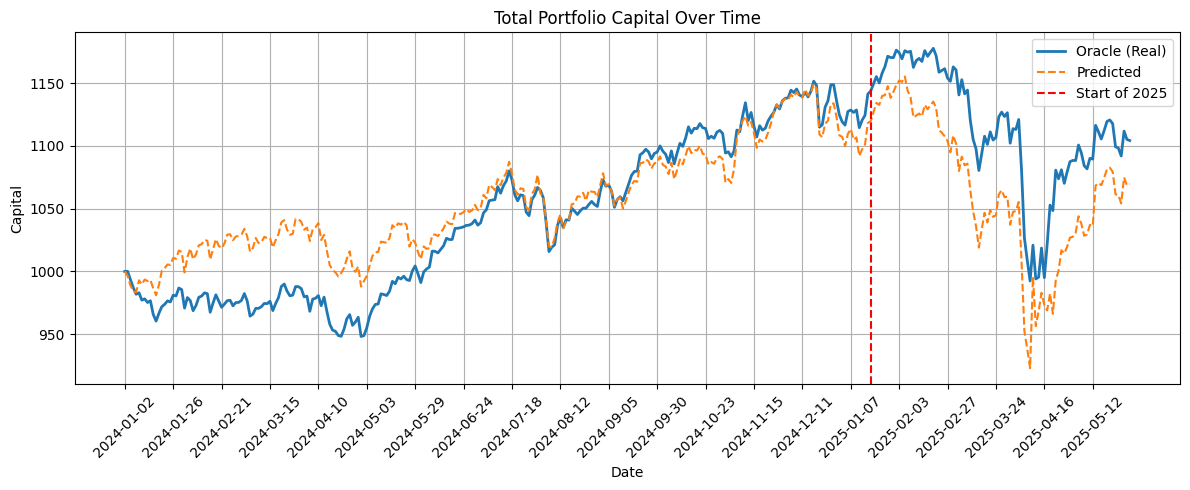

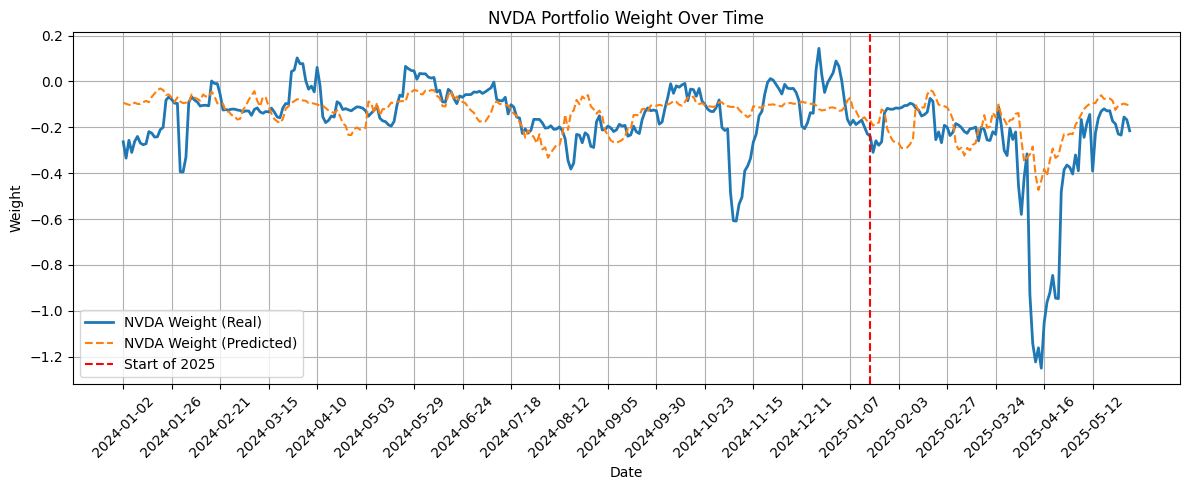

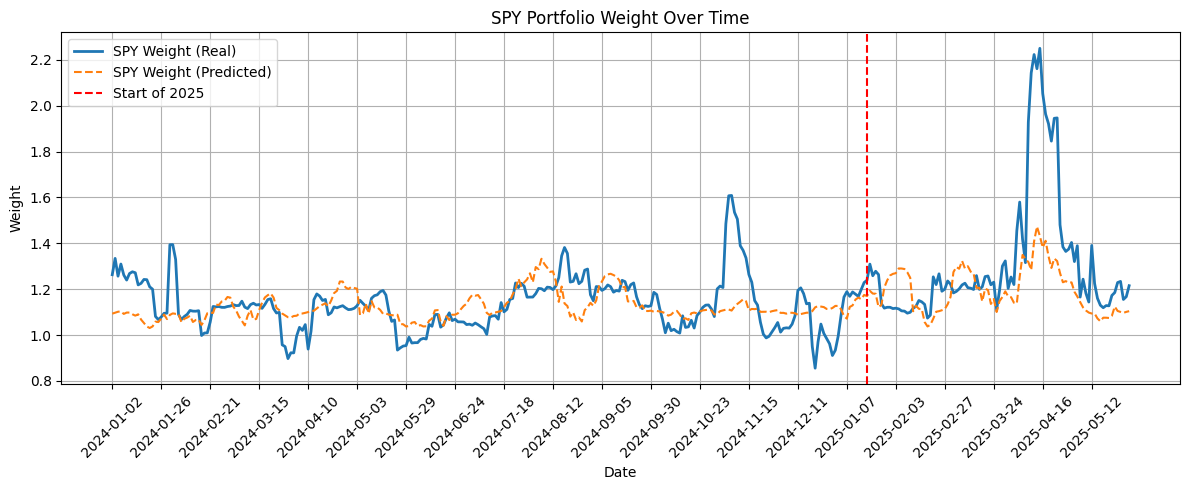

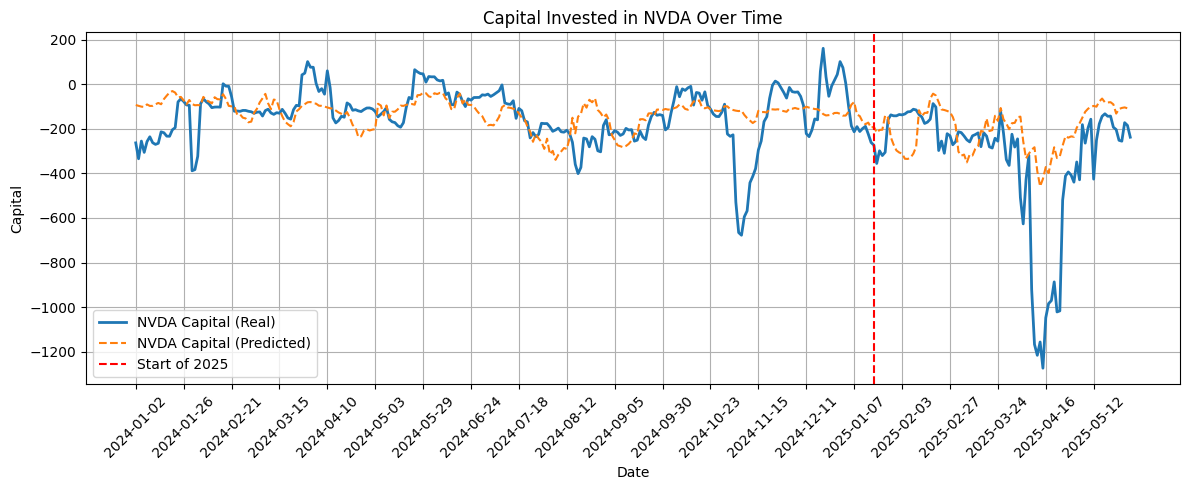

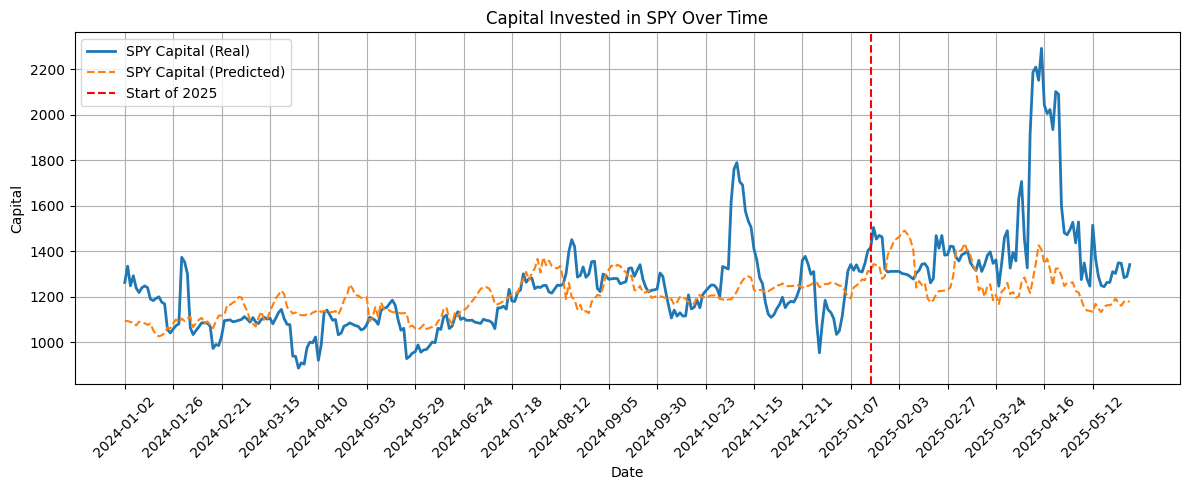

In [33]:
trading_days_2024 = pd.bdate_range(start='2024-01-01', end='2024-12-31')
start_2025_index = len(trading_days_2024)

time = list(range(len(oracle_result)))

## --- Total portfolio capital over time ---
#plt.figure(figsize=(12, 5))
#plt.plot(time, oracle_result, label='Oracle (Real)', linewidth=2)
#plt.plot(time, predicted_result, label='Predicted', linestyle='--')
#plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
#plt.title('Total Portfolio Capital Over Time')
#plt.xlabel('Time (Trading Days)')
#plt.ylabel('Capital')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#
## --- NVDA weights over time ---
#plt.figure(figsize=(12, 5))
#plt.plot(time, weights_nvda_oracle, label='NVDA Weight (Real)', linewidth=2)
#plt.plot(time, weights_nvda_pred, label='NVDA Weight (Predicted)', linestyle='--')
#plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
#plt.title('NVDA Portfolio Weight Over Time')
#plt.xlabel('Time (Trading Days)')
#plt.ylabel('Weight')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#
## --- SPY weights over time ---
#plt.figure(figsize=(12, 5))
#plt.plot(time, weights_spy_oracle, label='SPY Weight (Real)', linewidth=2)
#plt.plot(time, weights_spy_pred, label='SPY Weight (Predicted)', linestyle='--')
#plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
#plt.title('SPY Portfolio Weight Over Time')
#plt.xlabel('Time (Trading Days)')
#plt.ylabel('Weight')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#
## --- Capital invested in NVDA over time ---
#plt.figure(figsize=(12, 5))
#plt.plot(time, capital_NVDA_oracle, label='NVDA Capital (Real)', linewidth=2)
#plt.plot(time, capital_NVDA_pred, label='NVDA Capital (Predicted)', linestyle='--')
#plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
#plt.title('Capital Invested in NVDA Over Time')
#plt.xlabel('Time (Trading Days)')
#plt.ylabel('Capital')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#
## --- Capital invested in SPY over time ---
#plt.figure(figsize=(12, 5))
#plt.plot(time, capital_SPY_oracle, label='SPY Capital (Real)', linewidth=2)
#plt.plot(time, capital_SPY_pred, label='SPY Capital (Predicted)', linestyle='--')
#plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
#plt.title('Capital Invested in SPY Over Time')
#plt.xlabel('Time (Trading Days)')
#plt.ylabel('Capital')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()
#


date_range = dates[-len(oracle_result):]  # Use the actual dates for the test period
# --- Total portfolio capital over time ---
plt.figure(figsize=(12, 5))
plt.plot(date_range, oracle_result, label='Oracle (Real)', linewidth=2)
plt.plot(date_range, predicted_result, label='Predicted', linestyle='--')
plt.axvline(x=date_range[start_2025_index], color='red', linestyle='--', label='Start of 2025')
plt.title('Total Portfolio Capital Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.tight_layout()
plt.show()

# --- NVDA weights over time ---
plt.figure(figsize=(12, 5))
plt.plot(date_range, weights_nvda_oracle, label='NVDA Weight (Real)', linewidth=2)
plt.plot(date_range, weights_nvda_pred, label='NVDA Weight (Predicted)', linestyle='--')
plt.axvline(x=date_range[start_2025_index], color='red', linestyle='--', label='Start of 2025')
plt.title('NVDA Portfolio Weight Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.tight_layout()
plt.show()

# --- SPY weights over time ---
plt.figure(figsize=(12, 5))
plt.plot(date_range, weights_spy_oracle, label='SPY Weight (Real)', linewidth=2)
plt.plot(date_range, weights_spy_pred, label='SPY Weight (Predicted)', linestyle='--')
plt.axvline(x=date_range[start_2025_index], color='red', linestyle='--', label='Start of 2025')
plt.title('SPY Portfolio Weight Over Time')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend()
plt.grid(True)
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.tight_layout()
plt.show()

# --- Capital invested in NVDA over time ---
plt.figure(figsize=(12, 5))
plt.plot(date_range, capital_NVDA_oracle, label='NVDA Capital (Real)', linewidth=2)
plt.plot(date_range, capital_NVDA_pred, label='NVDA Capital (Predicted)', linestyle='--')
plt.axvline(x=date_range[start_2025_index], color='red', linestyle='--', label='Start of 2025')
plt.title('Capital Invested in NVDA Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.tight_layout()
plt.show()

# --- Capital invested in SPY over time ---
plt.figure(figsize=(12, 5))
plt.plot(date_range, capital_SPY_oracle, label='SPY Capital (Real)', linewidth=2)
plt.plot(date_range, capital_SPY_pred, label='SPY Capital (Predicted)', linestyle='--')
plt.axvline(x=date_range[start_2025_index], color='red', linestyle='--', label='Start of 2025')
plt.title('Capital Invested in SPY Over Time')
plt.xlabel('Date')
plt.ylabel('Capital')
plt.legend()
plt.grid(True)
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.tight_layout()
plt.show()



---


# 3 - Stress Testing Framework


## Standard case on train dataset

In [34]:
def get_VaR(alpha, mean, std):
  # norm.ppf(q, loc, scale) gives you the value x such that P(X ≤ x) = q for a normal distribution with mean loc and standard deviation scale.
    VaR = mean + (std*sps.norm.ppf(q=1-alpha,loc=0,scale=1))
    return VaR

def get_ES(alpha, mean, std):
  #This function approximates ES by averaging 40 quantiles beyond the VaR threshold.
    levels5 = np.linspace(0.001,1-alpha,40)
    q5 = sps.norm.ppf(levels5, 0, 1)
    mean5 = q5.mean()
    return mean + std*(mean5)

In [35]:
# save weights assigned in the simulation of the train
_, weights_nvda_pred_train, weights_spy_pred_train, _, _, returns_portfolio_train = run_portfolio_simulation(var_source='predicted', r1=train_df_r['rNVDA_today'], r2=train_df_r['rSPY_today'], dataframe=train_df, capital=1000, output=train_output)

INITIAL PORTFOLIO VALUE: 1000
FINAL PORTFOLIO VALUE: 2861.1512114976


In [36]:
# we have outputs already, create temporal matrix for the w to use the formula of variance of a portfolio
# columns of output are  ['cov', 'var_NVDA', 'var_SPY']
sigma_matrices = []
for pred in train_output:
    cov = pred[0]
    var_nvda = pred[1]
    var_spy = pred[2]
    sigma = np.array([[var_nvda, cov],
                      [cov, var_spy]])
    sigma_matrices.append(sigma)
print(sigma_matrices[1])

# now we create a temporal matrix, each day having w_0 of weights_nvda_pred_train and w_1 of weights_spy_pred_train
matrix_weights_train = np.array([weights_nvda_pred_train, weights_spy_pred_train]).T
print("----------")
print(weights_nvda_pred_train[0])
print(matrix_weights_train[0])

# now we create a matrix of the variance of the portfolio using the formula wT SIGMA w
variance_portfolio_pred_train = []
for i in range(len(matrix_weights_train)):
    variance_portfolio_pred_train.append(np.dot(matrix_weights_train[i].T, np.dot(sigma_matrices[i], matrix_weights_train[i])))

[[5.05305812e-04 9.83073261e-05]
 [9.83073261e-05 5.97313443e-05]]
----------
-0.09230735072405699
[-0.09230735  1.09230735]


In [37]:
print(matrix_weights_train[45])

[-0.09976768  1.09976768]


In [38]:
VaRs_P = []
ESs_P = []
alpha = 0.95
mu = 0
for var in (variance_portfolio_pred_train):
    std = np.sqrt(var)
    VaRs_P.append(get_VaR(alpha, mu, std))
    ESs_P.append(get_ES(alpha, mu, std))

VaRs_P = np.array(VaRs_P)
ESs_P = np.array(ESs_P)

print("Means VaRs:",VaRs_P.mean(), "Means ESs:",ESs_P.mean())
print("Max VaRs:",VaRs_P.max(), "Max ESs:",ESs_P.max())
print("Min VaRs:",VaRs_P.min(), "Min ESs:",ESs_P.min())

Means VaRs: -0.01504987548707182 Means ESs: -0.018712031783312797
Max VaRs: -0.009677819085464681 Max ESs: -0.012032767877443775
Min VaRs: -0.07577832908874965 Min ESs: -0.09421782283933744


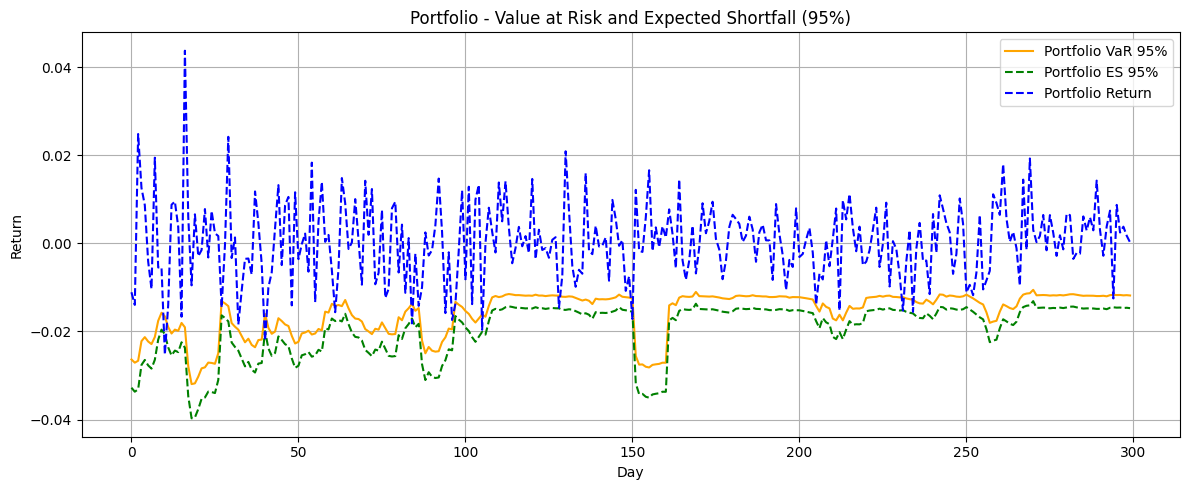

In [39]:
plt.figure(figsize=(12, 5))
plt.plot(VaRs_P[-301:-1], label='Portfolio VaR 95%', color='orange')
plt.plot(ESs_P[-301:-1], label='Portfolio ES 95%', color='green', linestyle='--')
plt.plot(returns_portfolio_train[-300:], label='Portfolio Return', color='blue', linestyle="--")
plt.title('Portfolio - Value at Risk and Expected Shortfall (95%)')
plt.xlabel('Day')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Dynamic scenario generation model

We define some dataset for arma and garch

In [40]:
# train_df_r
spy_r_log = (np.log1p(train_df_r['rSPY_today']))
spy_r_squared = (np.log1p(train_df_r['rSPY_today']))**2

nvda_r_log = (np.log1p(train_df_r['rNVDA_today']))
nvda_r_squared = (np.log1p(train_df_r['rNVDA_today']))**2

spy_test_r_log = (np.log1p(test_df_r['rSPY_today']))
spy_test_r_squared = (np.log1p(test_df_r['rSPY_today']))**2

nvda_test_r_log = (np.log1p(test_df_r['rNVDA_today']))
nvda_test_r_squared = (np.log1p(test_df_r['rNVDA_today']))**2

trading_days_2024 = dates[(dates >= '2024-01-01') & (dates <= '2024-12-31')]
start_2025_index = len(trading_days_2024)

train_length = len(spy_r_log)
test_length = len(spy_test_r_log)

assert len(spy_r_log) == len(spy_r_squared) == len(nvda_r_log) == len(nvda_r_squared), "Train sets do not have the same length"
assert len(spy_test_r_log) == len(spy_test_r_squared) == len(nvda_test_r_log) == len(nvda_test_r_squared), "Test sets do not have the same length"

In [41]:
# Convert to pandas Series for indexes
portfolio_returns_train = pd.Series(returns_portfolio_train)
portfolio_returns_test = pd.Series(returns_portfolio)

portfolio_r_log = (np.log1p(portfolio_returns_train))
portfolio_r_squared = (np.log1p(portfolio_returns_train))**2

portfolio_test_r_log = (np.log1p(portfolio_returns_test))
portfolio_test_r_squared = (np.log1p(portfolio_returns_test))**2

### ARMA

$$Y_t = \phi_0 + \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}$$
$$ \epsilon_t \sim N(0, \sigma^2)$$

In [42]:
def get_ARMA(returns):
    arma_model = arima.AutoARIMA(d=0,information_criterion="bic",suppress_warnings=True,trace=True)
    arma_model.fit(y=returns)
    return arma_model

def get_ARMA_predictions(arma_model,test_returns):
    arma_model.update(test_returns)
    prediction = arma_model.predict_in_sample()
    return prediction

def compute_VaR_ES(mean,variance,asset):

    variance = np.array(variance)

    train_VaR = get_VaR(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_VaR = get_VaR(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train "+asset+" mean VaR:")
    print(np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
    print("Test "+asset+" mean VaR:")
    print(np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())

    train_ES = get_ES(alpha=0.95, mean=mean[:train_length], std=variance[:train_length]**0.5)
    test_ES = get_ES(alpha=0.95, mean=mean[-test_length:], std=variance[-test_length:]**0.5)
    print("Train "+asset+" mean ES:")
    print(np.asarray(train_ES)[~np.isnan(train_ES)].mean())
    print("Test "+asset+" mean ES:")
    print(np.asarray(test_ES)[~np.isnan(test_ES)].mean())

    assert len(train_VaR) == train_length, "Train VaR length mismatch"
    assert len(test_VaR) == test_length, "Test VaR length mismatch"
    assert len(train_ES) == train_length, "Train ES length mismatch"
    assert len(test_ES) == test_length, "Test ES length mismatch"

    return train_VaR, test_VaR, train_ES, test_ES

def compute_backtest_results(train_returns, test_returns, train_VaR, test_VaR):
    print(f"Train VaR coverage: {(np.where((train_returns <= train_VaR), 1, 0)).mean():.6f}")
    print(f"Test VaR coverage: {(np.where((test_returns <= test_VaR), 1, 0)).mean():.6f}")

    test_returns_2024 = test_returns.iloc[:start_2025_index]
    test_VaR_2024 = test_VaR[:start_2025_index]

    test_returns_2025 = test_returns.iloc[start_2025_index:]
    test_VaR_2025 = test_VaR[start_2025_index:]

    print(f"Test VaR coverage (2024): {(np.where((test_returns_2024 <= test_VaR_2024), 1, 0)).mean():.6f}")
    print(f"Test VaR coverage (2025): {(np.where((test_returns_2025 <= test_VaR_2025), 1, 0)).mean():.6f}")


def plot_train_VaR_ES(train_returns, train_VaR, train_ES):
    tail = test_length
    n = train_length
    date_range = dates.values[n-tail:n]
    plt.figure(figsize=(14, 6))
    plt.plot(date_range, train_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, train_VaR[-tail:], label='VaR95')
    plt.plot(date_range, train_ES[-tail:], label='ES95')
    plt.title(f"VaR and ES (Last {tail} Train Data)")
    plt.xlabel("Date")
    plt.ylabel('Log Returns')
    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_test_VaR_ES(test_returns, test_VaR, test_ES):
    tail = test_length
    date_range = dates[-tail:]

    plt.figure(figsize=(14, 6))
    plt.plot(date_range, test_returns.iloc[-tail:], label='Log Returns')
    plt.plot(date_range, test_VaR[-tail:], label='VaR95')
    plt.plot(date_range, test_ES[-tail:], label='ES95')
    plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
    plt.title(f"VaR and ES (Test Data)")
    plt.xlabel("Date")
    plt.ylabel('Log Return')
    step = max(1, len(date_range) // 20)
    plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [43]:
portfolio_arma = get_ARMA(portfolio_r_squared)
print(portfolio_arma.summary())

Performing stepwise search to minimize bic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : BIC=-46773.014, Time=5.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : BIC=-45748.050, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : BIC=-46198.644, Time=2.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : BIC=-45995.775, Time=3.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : BIC=-45464.135, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : BIC=-46752.966, Time=4.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : BIC=-46784.200, Time=5.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : BIC=-46798.048, Time=5.57 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : BIC=-46209.454, Time=12.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : BIC=-46509.391, Time=7.38 sec
 ARIMA(1,0,1)(0,0,0)[0]             : BIC=-35999.473, Time=5.31 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 51.915 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observa

In [44]:
arma_portfolio_variance = get_ARMA_predictions(portfolio_arma, portfolio_test_r_squared)

print(arma_portfolio_variance[arma_portfolio_variance < 0].shape)
#clip the small amount of negative variances to a very small number, we take e-10 since it is the smallest variance that we get
arma_portfolio_variance = np.maximum(arma_portfolio_variance, 1e-10)
print(arma_portfolio_variance[arma_portfolio_variance < 0].shape)

zero_mean = np.zeros(train_length + test_length)

arma_train_portfolio_VaR, arma_test_portfolio_VaR, arma_train_portfolio_ES, arma_test_portfolio_ES = compute_VaR_ES(zero_mean, arma_portfolio_variance, "Portfolio")

(0,)
(0,)
Train Portfolio mean VaR:
-0.014096464207912269
Test Portfolio mean VaR:
-0.013462104527822493
Train Portfolio mean ES:
-0.017526622497134478
Test Portfolio mean ES:
-0.016737901121592944


In [45]:
compute_backtest_results(portfolio_r_log, portfolio_test_r_log, arma_train_portfolio_VaR, arma_test_portfolio_VaR)

Train VaR coverage: 0.066363
Test VaR coverage: 0.076271
Test VaR coverage (2024): 0.067460
Test VaR coverage (2025): 0.098039


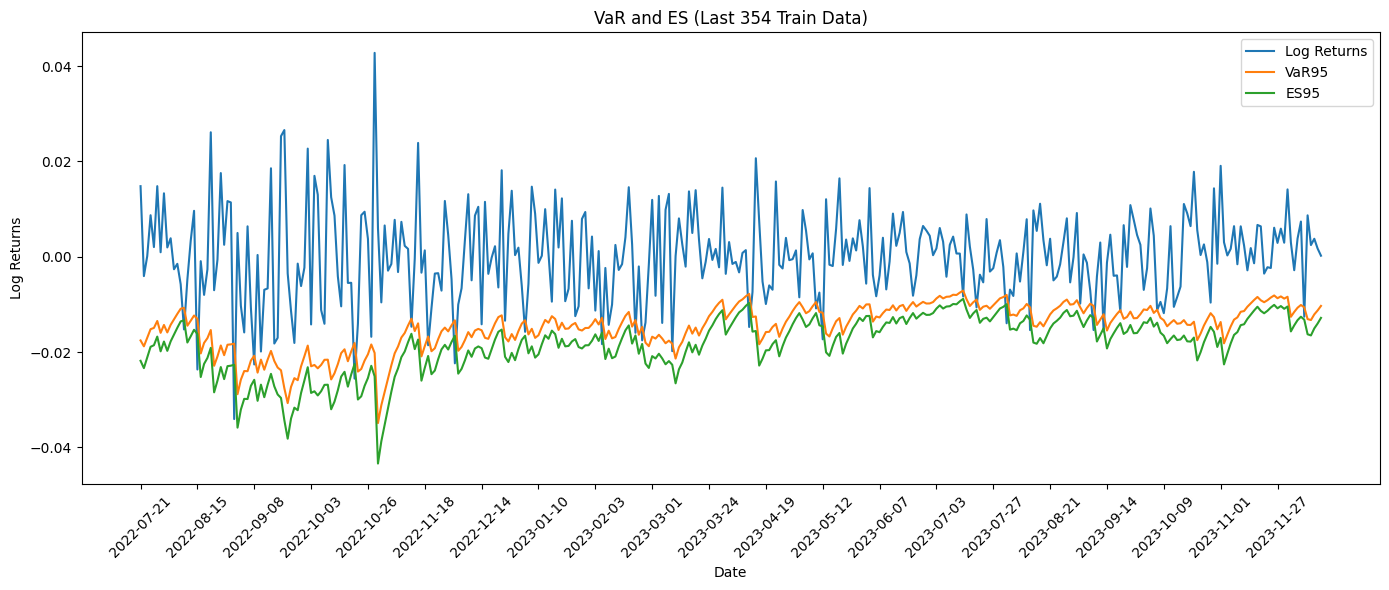

In [46]:
plot_train_VaR_ES(portfolio_r_log, arma_train_portfolio_VaR, arma_train_portfolio_ES)

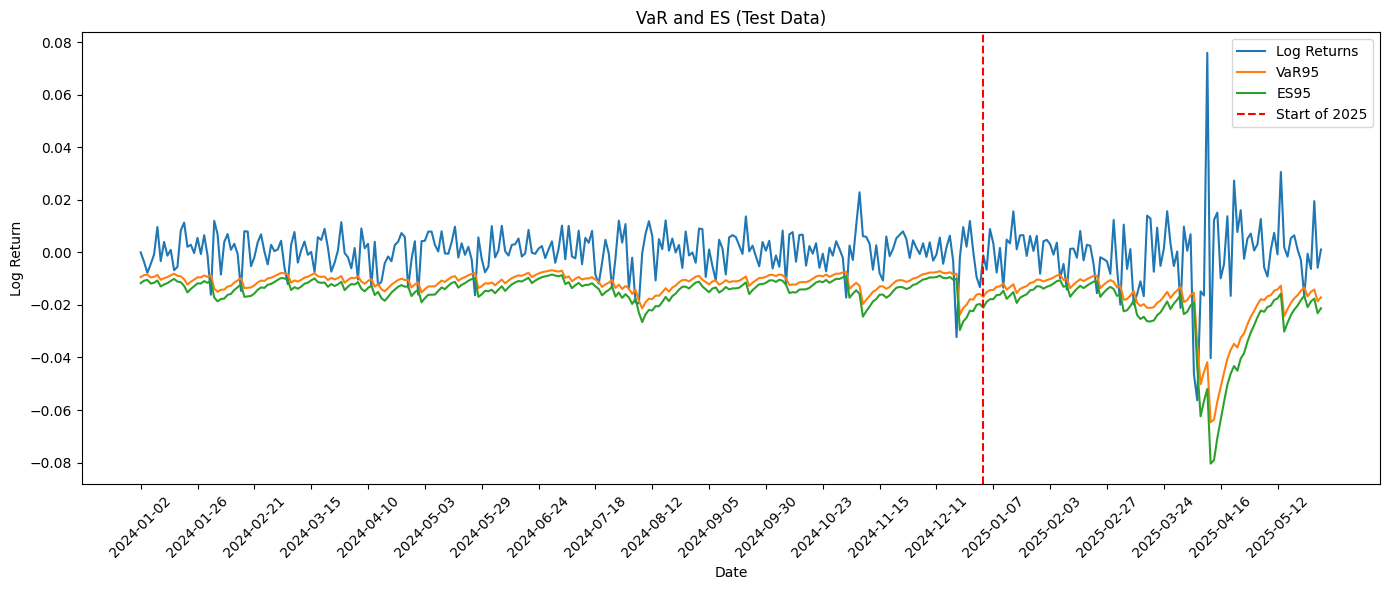

In [47]:
plot_test_VaR_ES(portfolio_test_r_log, arma_test_portfolio_VaR, arma_test_portfolio_ES)

### GARCH
The $GARCH(p, q)$ model is used to model the volatility of a financial asset over time. It captures the time-varying nature of volatility by allowing past squared returns and past volatility to influence current volatility.
It can be used in conjunction with $AR(r)$ model to capture both the mean and volatility dynamics of asset returns. This model is defined as follows:
$$
Y_t = \mu + \sum_{i=1}^{r} \phi_i Y_{t-i} + \epsilon_t \\
\text{where } \epsilon_t \sim \mathcal{N}(0, \sigma_t^2) \\
\sigma_t^2 = \omega + \sum_{i=1}^{p} \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^{q} \beta_j \sigma_{t-j}^2
$$
where:
- $\sigma_t^2$ is the conditional variance (volatility) at time $t$,
- $\omega$ is a constant term,
- $\alpha_i$ are the coefficients for past squared returns (ARCH terms),
- $\beta_j$ are the coefficients for past volatility (GARCH terms),
- $p$ is the order of the GARCH part,
- $q$ is the order of the ARCH part,
- $r$ is the order of the autoregressive part,
- $s$ is the order of the moving average part.

In [48]:
def get_GARCH(train_returns,test_returns,arma_p,rescale):
    distributions = ['t','skewt','normal']
    best_metric = np.inf
    best_model = None

    for dist in distributions:
        for p in range(1, 4):
            for q in range(1, 4):
                model = arch_model(pd.concat([train_returns,test_returns]), vol='GARCH', p=p, q=q, mean="Zero", lags=arma_p, dist=dist, rescale=rescale)
                res = model.fit(disp='off',update_freq=0, cov_type="robust",last_obs=train_length)

                if res.bic < best_metric:
                    best_metric = res.bic
                    best_model = res
                    best_config = (p, q, dist)
                print(f"Try: p={p}, q={q}, dist={dist}, BIC={res.bic:.2f}")

    print("Best config:", best_config)
    print("Best BIC:", best_metric)

    return best_model


def get_GARCH_prediction(garch_result):

    resid = garch_result.std_resid * garch_result.conditional_volatility
    train_mean = garch_result.model.y - resid

    train_variance = garch_result.conditional_volatility ** 2

    test_mean = garch_result.forecast(horizon=1,start=train_length).mean.values.flatten()
    test_variance = garch_result.forecast(horizon=1,start=train_length).variance.values.flatten()
    mean = np.concatenate([train_mean[:train_length], test_mean])
    variance = np.concatenate([train_variance[:train_length], test_variance])

    return mean, variance



In [49]:
scaler_portfolio_r_log = StandardScaler()
portfolio_r_log_s = scaler_portfolio_r_log.fit_transform(portfolio_r_log.values.reshape(-1, 1)).flatten()
portfolio_test_r_log_s = scaler_portfolio_r_log.transform(portfolio_test_r_log.values.reshape(-1, 1)).flatten()

portfolio_r_log_s = pd.Series(portfolio_r_log_s, index=portfolio_r_log.index)
portfolio_test_r_log_s = pd.Series(portfolio_test_r_log_s, index=portfolio_test_r_log.index)

In [50]:
garch_portfolio = get_GARCH(portfolio_r_log_s, portfolio_test_r_log_s, arma_p=3, rescale=False)
print("GARCH model summary:")
print(garch_portfolio.summary())

Try: p=1, q=1, dist=t, BIC=8486.10
Try: p=1, q=2, dist=t, BIC=8494.26
Try: p=1, q=3, dist=t, BIC=8502.42
Try: p=2, q=1, dist=t, BIC=8492.43
Try: p=2, q=2, dist=t, BIC=8499.41
Try: p=2, q=3, dist=t, BIC=8507.44
Try: p=3, q=1, dist=t, BIC=8500.60
Try: p=3, q=2, dist=t, BIC=8507.53
Try: p=3, q=3, dist=t, BIC=8515.60
Try: p=1, q=1, dist=skewt, BIC=8453.94
Try: p=1, q=2, dist=skewt, BIC=8462.10
Try: p=1, q=3, dist=skewt, BIC=8470.27
Try: p=2, q=1, dist=skewt, BIC=8459.81
Try: p=2, q=2, dist=skewt, BIC=8467.04
Try: p=2, q=3, dist=skewt, BIC=8474.85
Try: p=3, q=1, dist=skewt, BIC=8467.97
Try: p=3, q=2, dist=skewt, BIC=8475.08
Try: p=3, q=3, dist=skewt, BIC=8483.01
Try: p=1, q=1, dist=normal, BIC=8636.90
Try: p=1, q=2, dist=normal, BIC=8645.07
Try: p=1, q=3, dist=normal, BIC=8653.23
Try: p=2, q=1, dist=normal, BIC=8643.38
Try: p=2, q=2, dist=normal, BIC=8648.92
Try: p=2, q=3, dist=normal, BIC=8657.00
Try: p=3, q=1, dist=normal, BIC=8651.54
Try: p=3, q=2, dist=normal, BIC=8657.09
Try: p=3, q=3,

In [51]:
garch_portfolio_mean, garch_portfolio_variance = get_GARCH_prediction(garch_portfolio)
print("NaN count in garch_portfolio_mean:", np.isnan(garch_portfolio_mean).sum())
print("NaN count in garch_portfolio_variance:", np.isnan(garch_portfolio_variance).sum())

print("Length of garch_portfolio_mean:", len(garch_portfolio_mean))
print("Length of garch_portfolio_variance:", len(garch_portfolio_variance))

NaN count in garch_portfolio_mean: 0
NaN count in garch_portfolio_variance: 0
Length of garch_portfolio_mean: 3865
Length of garch_portfolio_variance: 3865


In [52]:
from arch.univariate.distribution import SkewStudent

def get_VaR_skewt(alpha, mean, std, eta, lam):
    skewt_dist = SkewStudent()
    q = skewt_dist.ppf(1 - alpha, [eta, lam])
    VaR = mean + std * q
    return VaR

def get_ES_skewt(alpha, mean, std, eta, lam, n_points=40):
    skewt_dist = SkewStudent()
    # Average quantiles in the left tail up to VaR
    levels = np.linspace(0.001, 1 - alpha, n_points)
    q = skewt_dist.ppf(levels, [eta, lam])
    mean_q = np.mean(q)
    ES = mean + std * mean_q
    return ES

def compute_VaR_ES_skewt(mean, variance, eta, lam, asset):
    variance = np.array(variance)
    std = np.sqrt(variance)

    train_VaR = get_VaR_skewt(alpha=0.95, mean=mean[:train_length], std=std[:train_length], eta=eta, lam=lam)
    test_VaR = get_VaR_skewt(alpha=0.95, mean=mean[-test_length:], std=std[-test_length:], eta=eta, lam=lam)

    train_ES = get_ES_skewt(alpha=0.95, mean=mean[:train_length], std=std[:train_length], eta=eta, lam=lam)
    test_ES = get_ES_skewt(alpha=0.95, mean=mean[-test_length:], std=std[-test_length:], eta=eta, lam=lam)

    print("Train", asset, "mean VaR (skewt):", np.asarray(train_VaR)[~np.isnan(train_VaR)].mean())
    print("Test", asset, "mean VaR (skewt):", np.asarray(test_VaR)[~np.isnan(test_VaR)].mean())
    print("Train", asset, "mean ES (skewt):", np.asarray(train_ES)[~np.isnan(train_ES)].mean())
    print("Test", asset, "mean ES (skewt):", np.asarray(test_ES)[~np.isnan(test_ES)].mean())

    assert len(train_VaR) == train_length, "Train VaR length mismatch"
    assert len(test_VaR) == test_length, "Test VaR length mismatch"
    assert len(train_ES) == train_length, "Train ES length mismatch"
    assert len(test_ES) == test_length, "Test ES length mismatch"

    return train_VaR, test_VaR, train_ES, test_ES

In [53]:
#garch_train_portfolio_VaR, garch_test_portfolio_VaR, garch_train_portfolio_ES, garch_test_portfolio_ES = compute_VaR_ES(garch_portfolio_mean, garch_portfolio_variance, "Portfolio")
params = garch_portfolio.params
eta = params['eta']      # degrees of freedom
skew = params['lambda']  # skewness

alpha = 0.95
garch_train_VaR_skewt, garch_test_VaR_skewt, garch_train_ES_skewt, garch_test_ES_skewt = compute_VaR_ES_skewt(
    garch_portfolio_mean, garch_portfolio_variance, eta, skew, "Portfolio"
)


Train Portfolio mean VaR (skewt): -1.519981066883357
Test Portfolio mean VaR (skewt): -1.456847661850138
Train Portfolio mean ES (skewt): -2.1095976266065275
Test Portfolio mean ES (skewt): -2.02197411318293


In [54]:
#compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, garch_train_portfolio_VaR, garch_test_portfolio_VaR)
compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, garch_train_VaR_skewt, garch_test_VaR_skewt)

Train VaR coverage: 0.055255
Test VaR coverage: 0.036723
Test VaR coverage (2024): 0.027778
Test VaR coverage (2025): 0.058824


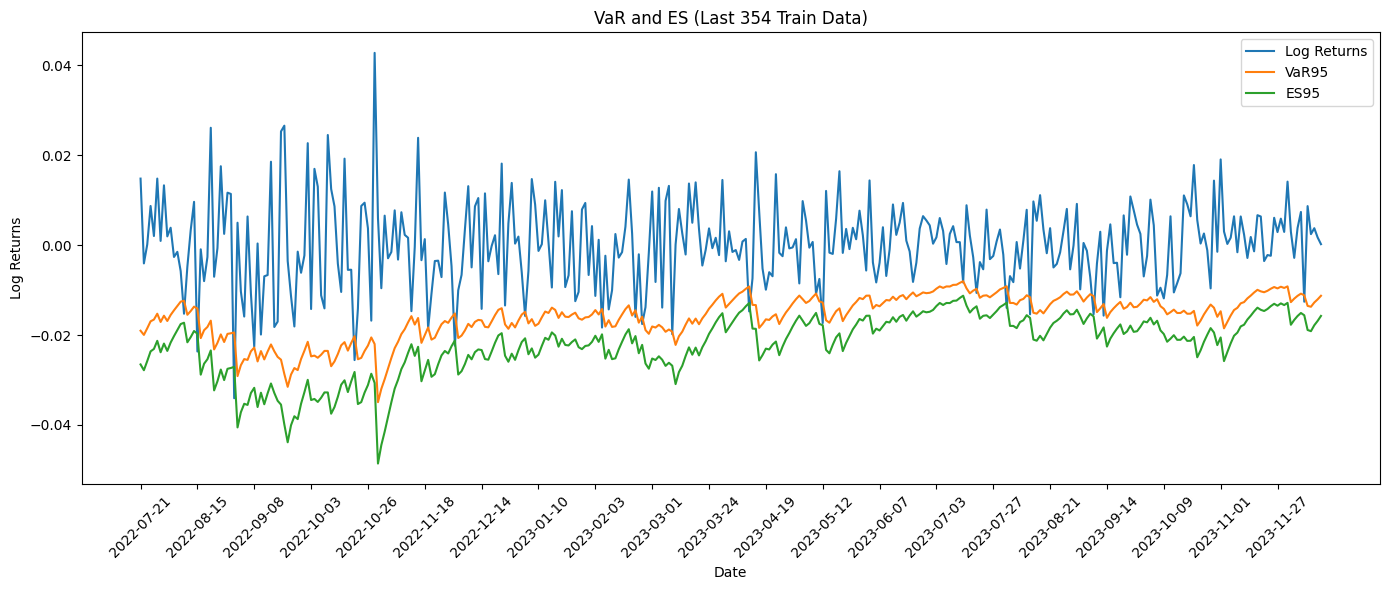

In [55]:
#garch_train_portfolio_VaR_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_portfolio_VaR.reshape(-1,1)).flatten())
#garch_train_portfolio_ES_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_portfolio_ES.reshape(-1,1)).flatten())
#
#plot_train_VaR_ES(portfolio_r_log, garch_train_portfolio_VaR_descaled, garch_train_portfolio_ES_descaled)

garch_train_VaR_skewt_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_VaR_skewt.reshape(-1,1)).flatten())
garch_train_ES_skewt_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_train_ES_skewt.reshape(-1,1)).flatten())

plot_train_VaR_ES(portfolio_r_log, garch_train_VaR_skewt_descaled, garch_train_ES_skewt_descaled)



---


# 4 - Model Evaluation and Backtesting

## Standard case on test dataset

In [56]:
# we have outputs already, create temporal matrix for the w to use the formula of variance of a portfolio
# columns of output are  ['cov', 'var_NVDA', 'var_SPY']
sigma_matrices = []
for pred in test_output:
    cov = pred[0]
    var_nvda = pred[1]
    var_spy = pred[2]
    sigma = np.array([[var_nvda, cov],
                      [cov, var_spy]])
    sigma_matrices.append(sigma)
print(sigma_matrices[1])

# now we create a temporal matrix, each day having w_0 of weights_nvda_pred_train and w_1 of weights_spy_pred_train
matrix_weights_pred = np.array([weights_nvda_pred, weights_spy_pred]).T
print("----------")
print(weights_nvda_pred[0])
print(matrix_weights_pred[0])

# now we create a matrix of the variance of the portfolio using the formula wT SIGMA w
variance_portfolio_pred = []
for i in range(len(matrix_weights_pred)):
    variance_portfolio_pred.append(np.dot(matrix_weights_pred[i].T, np.dot(sigma_matrices[i], matrix_weights_pred[i])))

[[4.78284713e-04 9.14448327e-05]
 [9.14448327e-05 5.71251466e-05]]
----------
-0.0933296246078877
[-0.09332962  1.09332962]


In [57]:
train_VaR_P, test_VaR_P, train_ES_P, test_ES_P = compute_VaR_ES(zero_mean, variance_portfolio_pred_train + variance_portfolio_pred, "Portfolio")

Train Portfolio mean VaR:
-0.01504987548707182
Test Portfolio mean VaR:
-0.016521577527053573
Train Portfolio mean ES:
-0.018712031783312797
Test Portfolio mean ES:
-0.02054184993505505


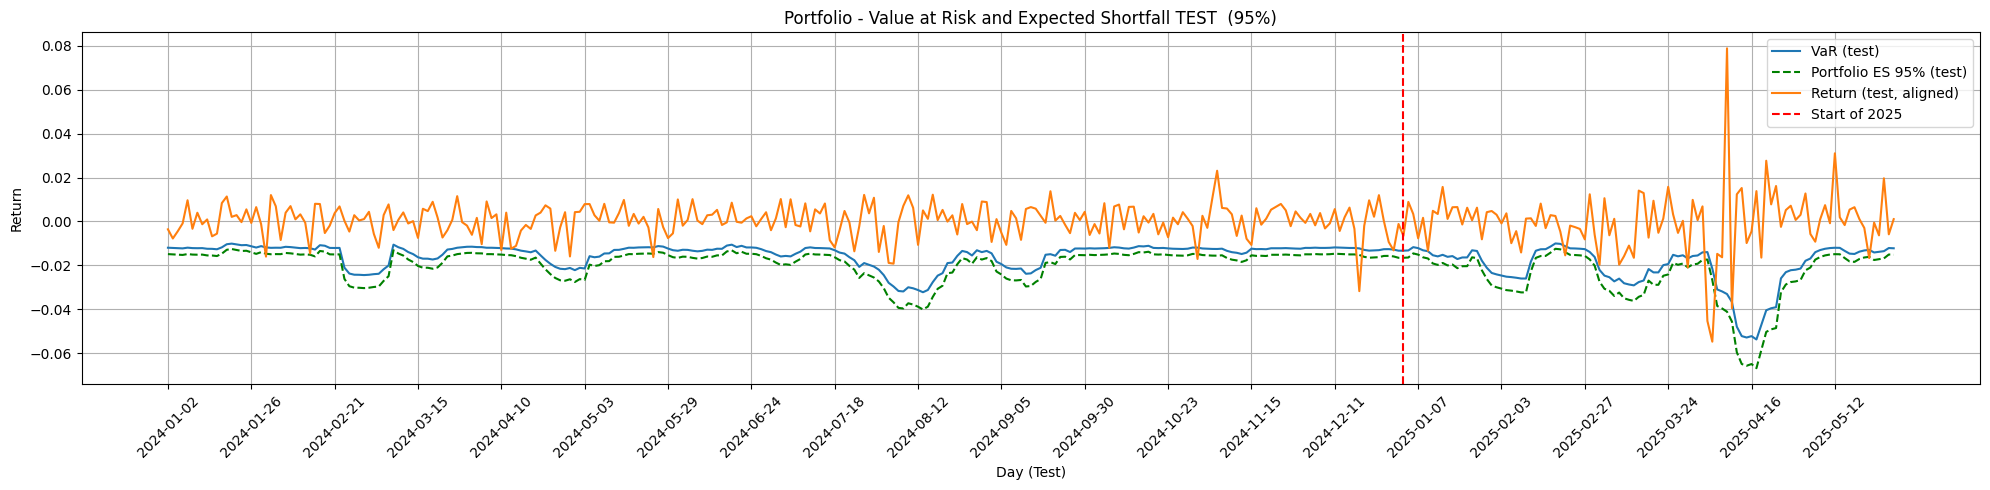

In [58]:
tail = test_length
date_range = dates[-tail:]

plt.figure(figsize=(20, 5))
plt.plot(test_VaR_P[:-1], label='VaR (test)')
plt.plot(test_ES_P[:-1], label='Portfolio ES 95% (test)', color='green', linestyle='--')
plt.plot(portfolio_returns_test[1:].reset_index(drop=True), label='Return (test, aligned)')
plt.axvline(x=start_2025_index, color='red', linestyle='--', label='Start of 2025')
step = max(1, len(date_range) // 20)
plt.xticks(ticks=np.arange(0, len(date_range), step), labels=date_range[::step], rotation=45)
plt.title('Portfolio - Value at Risk and Expected Shortfall TEST  (95%)')
plt.xlabel('Day (Test)')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now we can backtest

In [59]:
compute_backtest_results(portfolio_returns_train, portfolio_returns_test, train_VaR_P, test_VaR_P)

Train VaR coverage: 0.048704
Test VaR coverage: 0.033898
Test VaR coverage (2024): 0.027778
Test VaR coverage (2025): 0.049020


## Stress case


### Arma

Train VaR coverage: 0.066363
Test VaR coverage: 0.076271
Test VaR coverage (2024): 0.067460
Test VaR coverage (2025): 0.098039


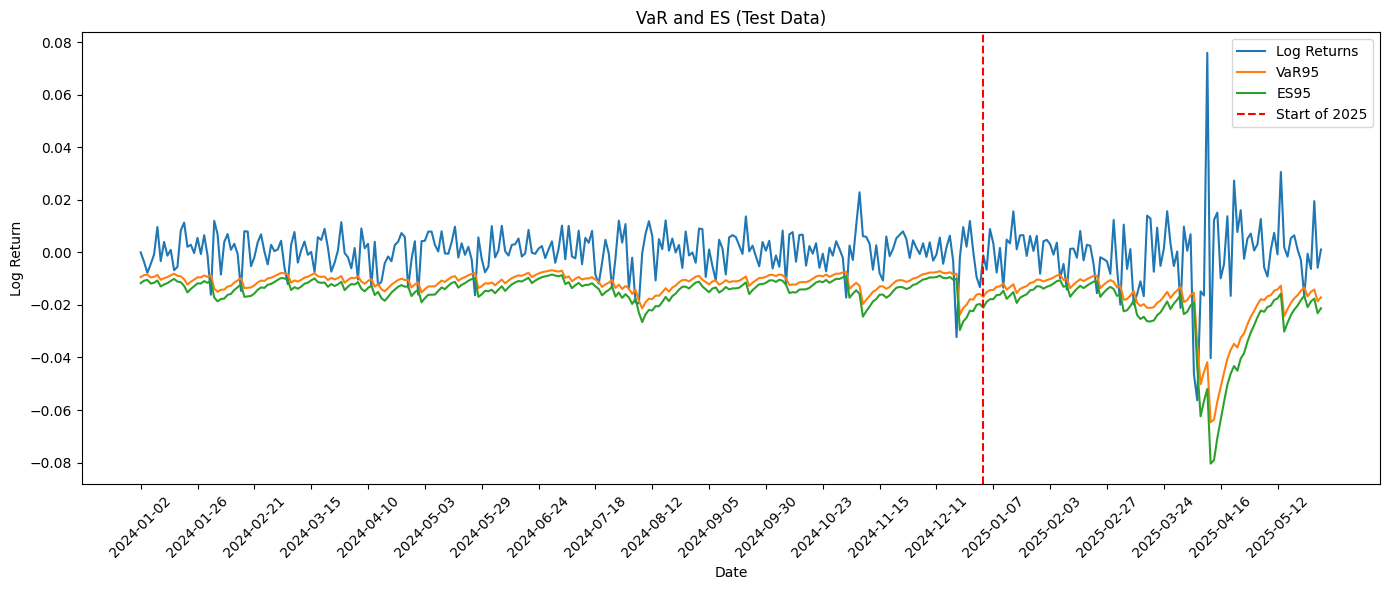

In [60]:
compute_backtest_results(portfolio_r_log, portfolio_test_r_log, arma_train_portfolio_VaR, arma_test_portfolio_VaR)
plot_test_VaR_ES(portfolio_test_r_log, arma_test_portfolio_VaR, arma_test_portfolio_ES)

### Garch

Train VaR coverage: 0.055255
Test VaR coverage: 0.036723
Test VaR coverage (2024): 0.027778
Test VaR coverage (2025): 0.058824


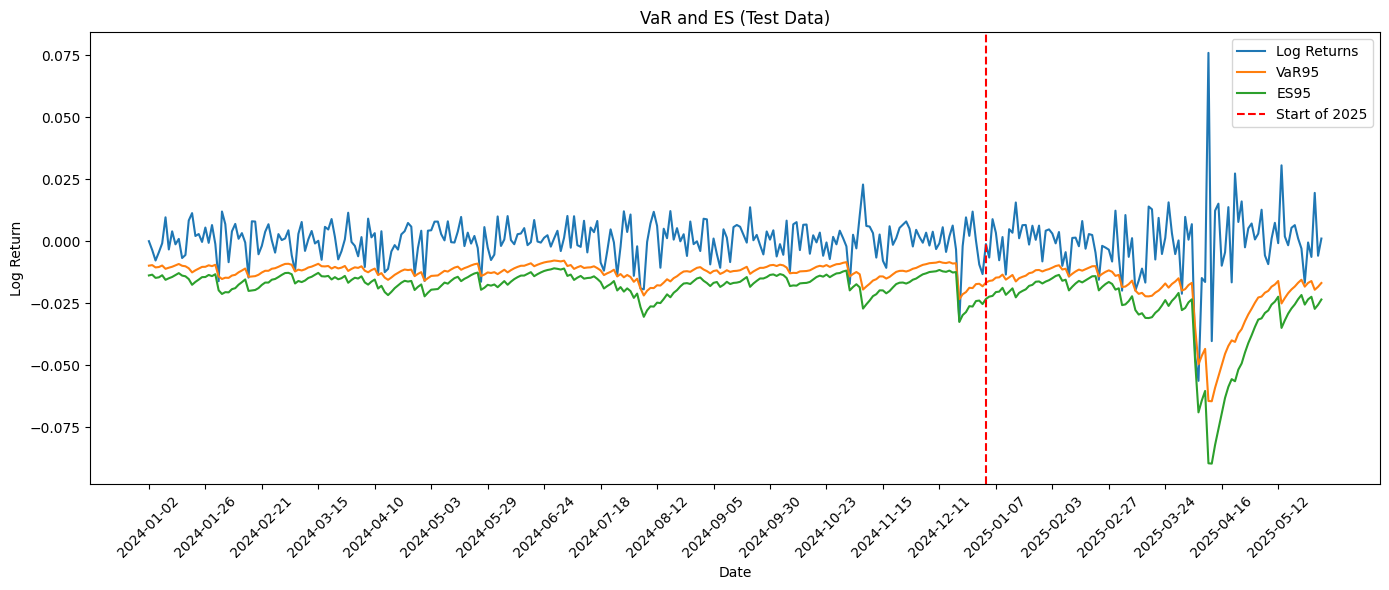

In [61]:
compute_backtest_results(portfolio_r_log_s, portfolio_test_r_log_s, garch_train_VaR_skewt, garch_test_VaR_skewt)

# descale the values to have coerent graph
garch_test_portfolio_VaR_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_test_VaR_skewt.reshape(-1,1)).flatten())
garch_test_portfolio_ES_descaled = pd.Series(scaler_portfolio_r_log.inverse_transform(garch_test_ES_skewt.reshape(-1,1)).flatten())

plot_test_VaR_ES(portfolio_test_r_log, garch_test_portfolio_VaR_descaled, garch_test_portfolio_ES_descaled)

## Asses performances

We evaluate The VaR coverage (percentage of losses that exceeded the predicted VaR threshold) on both training and test datasets, with a specific focus on two periods within the test data: 2024 and 2025. This allows us to observe how the model’s performance varies across different market conditions.

### Standard Case

| Period       | VaR Coverage Rate |
|--------------|-----------------|
| Train        | 5.21%           |
| Test         | 2.90%           |
| 2024         | 2.38%           |
| 2025         | 4.30%           |

- The model shows good performance overall. On the training data, the VaR coverage is close to the expected 5%, indicating a good risk estimation.
- In the test set, we observe a difference between 2024 and 2025, with 2025 being more challenging for the model. This suggests that market conditions or volatility in 2025 were different or more difficult to predict.
- In the test set, the model tends to overestimate risk. To further investigate this behavior, we introduce a stress testing scenario to better assess model robustness under more volatile conditions.
---

### Stress Case – ARMA Model


| Period             | VaR Coverage Rate |
|--------------------|-------------------|
| Train              | 6.41%             |
| Test               | 7.25%             |
| Test (2024)        | 6.35%             |
| Test (2025)        | 9.68%             |


- On the training data, the coverage is about 6.41%, slightly above the typical 5% threshold, indicating the model has underestimated the risk.
- In the test data overall (7.25%), the coverage is even higher, suggesting the model is underestimating risk.
- Looking more closely, in 2024 (6.35%), the model performs closer to training levels, but in 2025 (9.68%), the coverage spikes significantly.
- This indicates **2025 was a stress period with more extreme losses**, which the model had difficulty predicting accurately, leading to more frequent violations of the VaR threshold.


### Stress Case – GARCH Model


| Period       | VaR Coverage Rate |
|--------------|-------------------|
| Train        | 5.50%             |
| Test         | 4.64%             |
| 2024         | 3.57%             |
| 2025         | 7.53%             |

- On the training data, the VaR coverage is approximately 5.5%, which is close to the expected level, indicating reliable risk estimation.
- In the overall test set, the coverage drops to about 4.6%, suggesting good results with a tendency to be conservative.
- For 2024, the coverage further decreases to 3.6%, meaning the model is more conservative during this period.
- However, in 2025, the coverage rises sharply to 7.5%, reflecting a more stressful market environment where the model underestimates risk and fails to capture the increased frequency of extreme losses.


### Comparison ARMA and GARCH
- GARCH has better results than ARMA during training.
- On the test data overall, ARMA shows a higher breach rate (7.25%) than GARCH (4.64%), indicating ARMA underestimates risk more significantly in unseen data.
- For 2024, both models have relatively low breach rates, with GARCH (3.57%) being more conservative than ARMA (6.35%).
- In 2025, a challenging period, both models struggle, but ARMA has a substantially higher breach rate (9.68%) compared to GARCH (7.53%), suggesting that ARMA underestimates extreme losses more during volatile periods.
- Overall, GARCH appears more conservative, particularly in calmer market periods, while ARMA tends to underestimate risk more during stress periods.


In conclusion we can derive that GARCH provides a more cautious risk estimate and ARMA is less conservative but potentially more prone to large violations.

---
